In [1]:
import numpy as np

def crcbgenqcsig(dataX, snr, qcCoefs):
    """
    Generate a quadratic chirp signal
    
    Parameters:
    -----------
    dataX : array-like
        Vector of time stamps at which the samples of the signal are to be computed
    snr : float
        Matched filtering signal-to-noise ratio
    qcCoefs : array-like
        Vector of three coefficients [a1, a2, a3] that parametrize the phase 
        of the signal: a1*t + a2*t^2 + a3*t^3
    
    Returns:
    --------
    sigVec : numpy.ndarray
        
    """
    # Convert inputs to numpy arrays for element-wise operations
    dataX = np.array(dataX)
    qcCoefs = np.array(qcCoefs)
    
    # Calculate phase vector: a1*t + a2*t^2 + a3*t^3
    phaseVec = qcCoefs[0] * dataX + qcCoefs[1] * dataX**2 + qcCoefs[2] * dataX**3
    
    # Generate the signal using sine function
    sigVec = np.sin(2 * np.pi * phaseVec)
    
    # Normalize and scale by SNR
    sigVec = snr * sigVec / np.linalg.norm(sigVec)
    
    return sigVec

# # Example usage:
# if __name__ == "__main__":
#     # Example parameters
#     t = np.linspace(0, 1, 1000)  # Time vector from 0 to 1 second, 1000 samples
#     snr = 10                     # Signal-to-noise ratio
#     coeffs = [1, 5, 2]          # Quadratic chirp coefficients [a1, a2, a3]
    
#     # Generate the signal
#     signal = crcbgenqcsig(t, snr, coeffs)
    
#     print(f"Generated signal with {len(signal)} samples")
#     print(f"Signal range: [{np.min(signal):.4f}, {np.max(signal):.4f}]")
#     print(f"Signal norm: {np.linalg.norm(signal):.4f}")



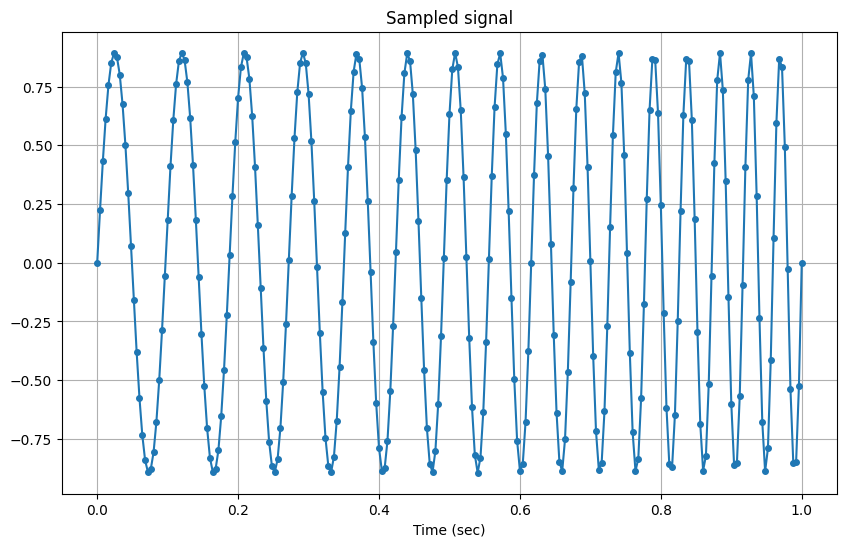

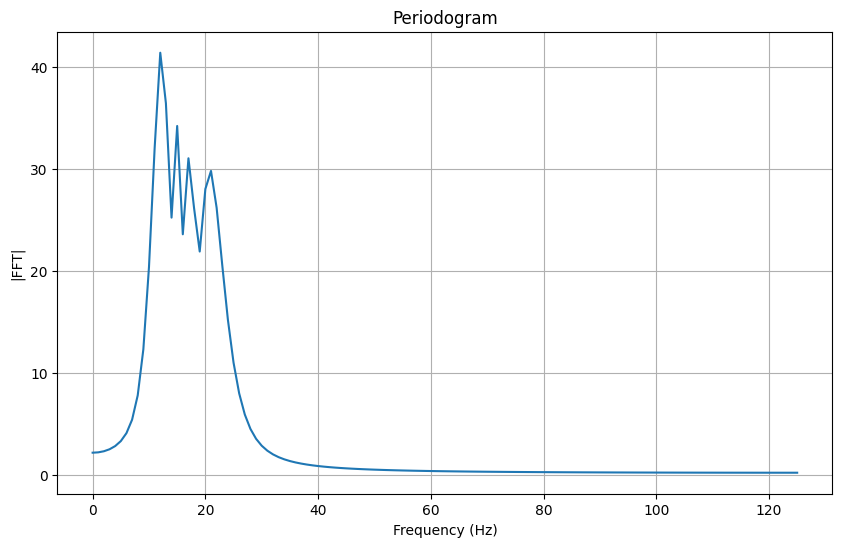

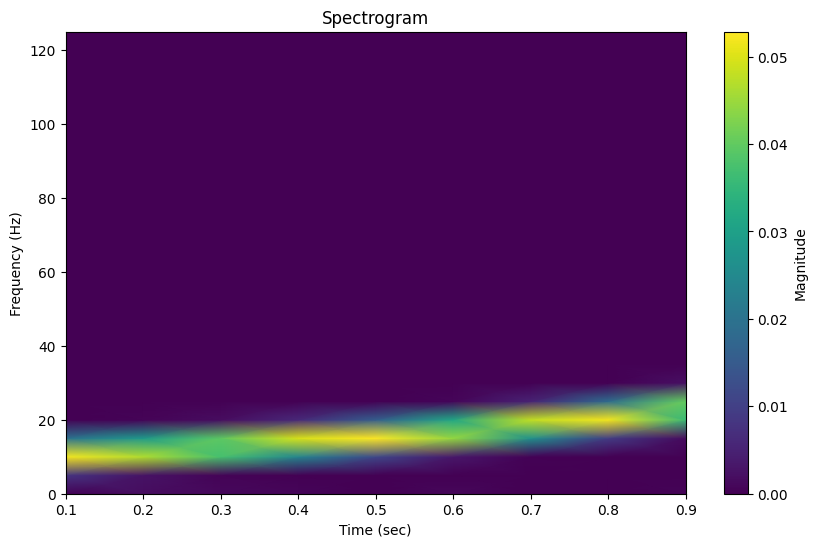

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Plot the quadratic chirp signal
# Signal parameters
a1 = 10
a2 = 3
a3 = 3
A = 10

# Instantaneous frequency after 1 sec is
maxFreq = a1 + 2*a2 + 3*a3

# Nyquist frequency guess: 2 * max. instantaneous frequency
nyqFreq = 2 * maxFreq

# Sampling frequency
samplFreq = 5 * nyqFreq
samplIntrvl = 1 / samplFreq

# Time samples
timeVec = np.arange(0, 1.0 + samplIntrvl, samplIntrvl)

# Number of samples
nSamples = len(timeVec)

# Generate the signal
sigVec = crcbgenqcsig(timeVec, A, [a1, a2, a3])


# Plot the signal
plt.figure(figsize=(10, 6))
plt.plot(timeVec, sigVec, marker='.', markersize=8)
plt.xlabel('Time (sec)')
plt.title('Sampled signal')
plt.grid(True)
plt.show()

# Plot the periodogram
# -------------------
# Length of data
dataLen = timeVec[-1] - timeVec[0]

# DFT sample corresponding to Nyquist frequency
kNyq = int(np.floor(nSamples/2)) +1

# Positive Fourier frequencies
posFreq = np.arange(0, kNyq) * (1/dataLen)

# FFT of signal
fftSig = np.fft.fft(sigVec)

# Discard negative frequencies
fftSig = fftSig[:kNyq]

# Plot periodogram
plt.figure(figsize=(10, 6))
plt.plot(posFreq, np.abs(fftSig))
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT|')
plt.title('Periodogram')
plt.grid(True)
plt.show()

# Plot a spectrogram
# ------------------
winLen = 0.2  # sec
ovrlp = 0.1   # sec

# Convert to integer number of samples
winLenSmpls = int(np.floor(winLen * samplFreq))
ovrlpSmpls = int(np.floor(ovrlp * samplFreq))

f, t, Sxx = spectrogram(sigVec, fs=samplFreq, window='hann', 
                        nperseg=winLenSmpls, noverlap=ovrlpSmpls)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()

# # Example usage of the function:
# if __name__ == "__main__":
#     print(f"Generated signal with {len(sigVec)} samples")
#     print(f"Signal range: [{np.min(sigVec):.4f}, {np.max(sigVec):.4f}]")
#     print(f"Signal norm: {np.linalg.norm(sigVec):.4f}")
#     print(f"Sampling frequency: {samplFreq:.2f} Hz")
#     print(f"Max instantaneous frequency: {maxFreq:.2f} Hz")

The maximum frequency of the quadratic chirp is 141.88


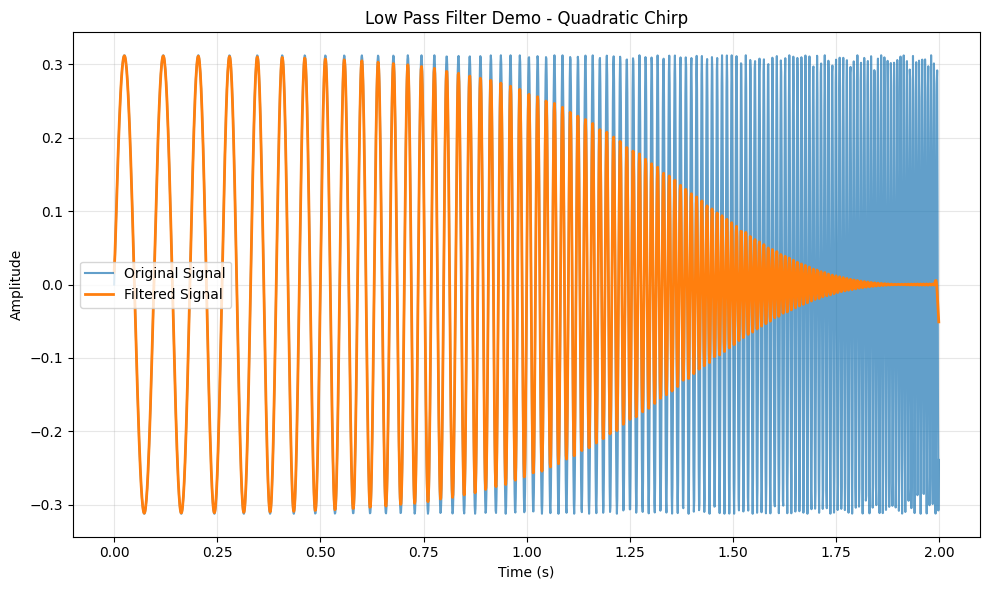

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Low pass filter demo
samp_freq = 1024
n_samples = 2048
time_vec = np.arange(n_samples) / samp_freq

# Quadratic chirp signal
# Signal parameters
a1 = 10
a2 = 3
a3 = 10
A = 10

# Signal length
sig_len = (n_samples - 1) / samp_freq

# Maximum frequency
max_freq = a1 + 2*a2*sig_len + 3*a3*sig_len**2
print(f'The maximum frequency of the quadratic chirp is {max_freq:.2f}')

# Generate signal
sig_vec = crcbgenqcsig(time_vec, A, [a1, a2, a3])

# Remove frequencies above half the maximum frequency
# Design low pass filter
filt_order = 30
# Create FIR filter with cutoff at half the maximum frequency
# Normalize by Nyquist frequency (samp_freq/2)
normalized_cutoff = (max_freq/2) / (samp_freq/2)
b = signal.firwin(filt_order + 1, normalized_cutoff)

# Apply filter using FFT-based convolution 
filt_sig = signal.fftconvolve(sig_vec, b, mode='same')

# Plots
plt.figure(figsize=(10, 6))
plt.plot(time_vec, sig_vec, label='Original Signal', alpha=0.7)
plt.plot(time_vec, filt_sig, label='Filtered Signal', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Low Pass Filter Demo - Quadratic Chirp')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# # Optional: Show frequency response of the filter
# plt.figure(figsize=(10, 4))
# w, h = signal.freqz(b, worN=8000)
# frequencies = w * samp_freq / (2 * np.pi)
# plt.plot(frequencies, 20 * np.log10(abs(h)))
# plt.axvline(max_freq/2, color='r', linestyle='--', label=f'Cutoff: {max_freq/2:.1f} Hz')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude (dB)')
# plt.title('Filter Frequency Response')
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.xlim(0, samp_freq/2)
# plt.tight_layout()
# plt.show()